In [1]:
from __future__ import print_function, division
%matplotlib inline

try:
    reload  # Python 2.7
except NameError:
    try:
        from importlib import reload  # Python 3.4+
    except ImportError:
        from imp import reload  # Python 3.0 - 3.3

In [2]:
import numpy as np
import modisco
import theano
print("Theano version:",theano.__version__)
import sys
print (sys.version)

WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: GeForce GT 750M (CNMeM is disabled, cuDNN 5005)
/Users/avantishrikumar/anaconda/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Couldn't import dot_parser, loading of dot files will not be possible.
Theano version: 0.9.0
2.7.12 |Anaconda 2.1.0 (x86_64)| (default, Jul  2 2016, 17:43:17) 
[GCC 4.2.1 (Based on Apple Inc. build 5658) (LLVM build 2336.11.00)]


## Grab the input data

In [3]:
!./grab_data.sh

File task0importancescores.npy exists already
File task0hypimpscores.npy exists already
File sequences.txt exists already


### Functions for one-hot encoding sequences

In [3]:
import gzip

def one_hot_encode_along_channel_axis(sequence):
    #theano dim ordering, uses row axis for one-hot
    to_return = np.zeros((len(sequence),4), dtype=np.int8)
    seq_to_one_hot_fill_in_array(zeros_array=to_return,
                                 sequence=sequence, one_hot_axis=1)
    return to_return

def seq_to_one_hot_fill_in_array(zeros_array, sequence, one_hot_axis):
    assert one_hot_axis==0 or one_hot_axis==1
    if (one_hot_axis==0):
        assert zeros_array.shape[1] == len(sequence)
    elif (one_hot_axis==1): 
        assert zeros_array.shape[0] == len(sequence)
    #will mutate zeros_array
    for (i,char) in enumerate(sequence):
        if (char=="A" or char=="a"):
            char_idx = 0
        elif (char=="C" or char=="c"):
            char_idx = 1
        elif (char=="G" or char=="g"):
            char_idx = 2
        elif (char=="T" or char=="t"):
            char_idx = 3
        elif (char=="N" or char=="n"):
            continue #leave that pos as all 0's
        else:
            raise RuntimeError("Unsupported character: "+str(char))
        if (one_hot_axis==0):
            zeros_array[char_idx,i] = 1
        elif (one_hot_axis==1):
            zeros_array[i,char_idx] = 1

#read in the data in the testing set
test_ids_fh = gzip.open("test.txt.gz","rb")
ids_to_load = set([x.rstrip("\n") for x in test_ids_fh])

fasta_sequences = []
for i,a_line in enumerate(gzip.open("sequences.simdata.gz","rb")):
    if (i==0):
        next
    a_line = a_line.rstrip()
    seq_id,seq_fasta,embeddings,task1,task2,task3 = a_line.split("\t")
    if seq_id in ids_to_load:
        fasta_sequences.append(seq_fasta)

## Prepare the data for input into TF-MoDISCo

You need a numpy array of importance scores and hypothetical importance scores for every task.

In [4]:
import h5py
from collections import OrderedDict

task_to_scores = OrderedDict()
task_to_hyp_scores = OrderedDict()

f = h5py.File("scores.h5","r")
tasks = f["contrib_scores"].keys()
for task in tasks:
    task_to_scores[task] = np.array(f['contrib_scores'][task])
    task_to_hyp_scores[task] = np.array(f['hyp_contrib_scores'][task])

onehot_data = np.array([one_hot_encode_along_channel_axis(seq) for seq in fasta_sequences])

Double check by plotting

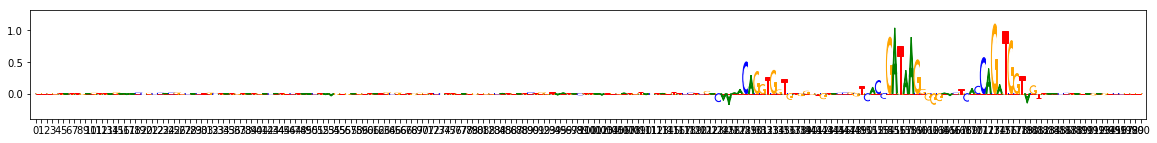

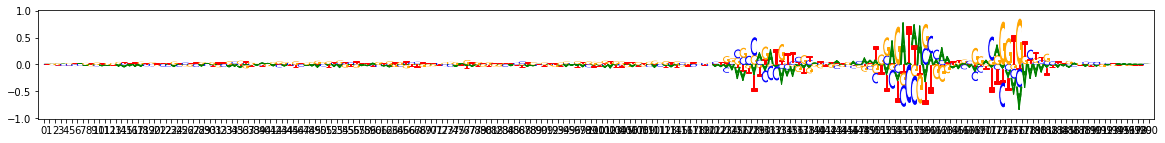

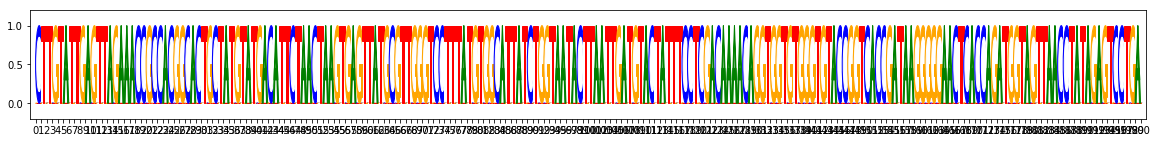

In [10]:
import modisco.visualization
from modisco.visualization import viz_sequence

viz_sequence.plot_weights(task_to_scores['task0'][0])
viz_sequence.plot_weights(task_to_hyp_scores['task0'][0])
viz_sequence.plot_weights(onehot_data[0])

## Run TF-MoDISco

TF-MoDISco first identifies seqlets, then splits the seqlets into "metaclusters" according to their pattern of activity across all the tasks, and then performs clustering within each task. Since there is just one task, there are only 2 possible metaclusters: +1 for the task and -1 for the task. The -1 metacluster does not turn up any motifs after noise filtering, but the +1 metacluster produces two motifs.

To demonstrate customization, the code below has slight modifications from default settings in the following ways:
- Because the TAL and GATA motifs are relatively short compared to something like CTCF, it uses a sliding window size of 15 (rather than the default of 21) and flanks of 5 (rather than the default of 10). The sliding window size and flanks should be adjusted according to the expected length of the core motif and its flanks. If the window size or flank sizes are too long, you risk picking up more noise.
- During the seqlet clustering, motifs are trimmed to the central `trim_to_window_size` bp with the highest importance. `trim_to_window_size` is set to 10 rather than the default of 30. After the trimming is done, the seqlet is expanded on either side by `initial_flank_to_add`. This is set to 3 rather than the default of 10.
- The `final_min_cluster_size` is set to 60 rather than the default of 30. This is used to filter out small clusters with relatively weak support (in this case, fewer than 50 seqlets).
- It uses kmers of length 5 with 1 gap and no mismatches to compute the "quick and dirty" affinity matrix across all seqlets. The "quick and dirty" affinity matrix is used both for noise filtering and as a first pass to speed up computation of the continuous jaccard affinity matrix (the latter affinities are only computed between seqlets deemed to be close together by the "quick and dirty" method). I made the kmer length smaller to keep memory usage on the GPU down when testing on my macbook pro. The default is to use kmers of length 8 with 3 gaps and 2 mismatches, and this works fine on more modern GPUs than the one in my 4-year-old macbook.

On task task0
Done 0


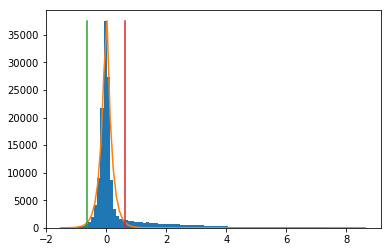

Computed threshold 0.6416451864009939
Done 0
Done 0
Done 0
Done 0
Done 0
Done 0
Done 0
Done 0
Done 0
Done 0
Got 7573 coords
1851 coords remaining after thresholding
On task task1
Done 0


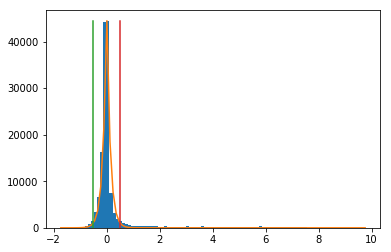

Computed threshold 0.5160285779594265
Done 0
Done 0
Done 0
Done 0
Done 0
Done 0
Done 0
Done 0
Done 0
Done 0
Got 7575 coords
1530 coords remaining after thresholding
On task task2
Done 0


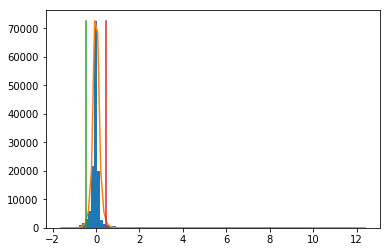

Computed threshold 0.445660070894207
Done 0
Done 0
Done 0
Done 0
Done 0
Done 0
Done 0
Done 0
Done 0
Done 0
Got 7575 coords
1653 coords remaining after thresholding
After resolving overlaps, got 2660 seqlets
5 activity patterns with support >= 200 out of 27 possible patterns
Metacluster sizes:  [831, 656, 420, 387, 305]
Idx to activities:  {0: '1,0,1', 1: '1,1,0', 2: '0,1,0', 3: '0,0,1', 4: '1,1,1'}
On metacluster 4
Metacluster size 305
Relevant tasks:  ('task0', 'task1', 'task2')
Relevant signs:  (1, 1, 1)
(Round 1) num seqlets: 305
(Round 1) Computing coarse affmat
Beginning embedding computation
Computing embeddings
Finished embedding computation in 0.39 s
Starting affinity matrix computations
Normalization computed in 0.0 s
Cosine similarity mat computed in 0.01 s
Normalization computed in 0.0 s
Cosine similarity mat computed in 0.0 s
Finished affinity matrix computations in 0.01 s
(Round 1) Compute nearest neighbors from coarse affmat
Computed nearest neighbors in 0.01 s
(Round 1) 

[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.2s
[Parallel(n_jobs=20)]: Done 200 out of 200 | elapsed:    1.2s finished


Louvain completed 200 runs in 1.59220504761 seconds
Wrote graph to binary file in 0.0547440052032 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.601468
Louvain completed 51 runs in 0.808898925781 seconds
Preproc + Louvain took 2.52308821678 s
Got 7 clusters after round 1
Counts:
{0: 111, 1: 81, 2: 48, 3: 38, 4: 10, 5: 3, 6: 3}
(Round 1) Aggregating seqlets in each cluster
Aggregating for cluster 0 with 111 seqlets
Trimmed 10 out of 111
Skipped 6 seqlets
Dropping cluster 0 with 95 seqlets due to sign disagreement
Aggregating for cluster 1 with 81 seqlets
Trimmed 5 out of 81
Skipped 3 seqlets
Aggregating for cluster 2 with 48 seqlets
Trimmed 4 out of 48
Skipped 5 seqlets
Aggregating for cluster 3 with 38 seqlets
Trimmed 1 out of 38
Skipped 3 seqlets
Dropping cluster 3 with 34 seqlets due to sign disagreement
Aggregating for cluster 4 with 10 seqlets
Trimmed 0 out of 10
Aggregating for cluster 5 with 3 seqlets
Trimmed 0 out of 3
Dropping cluster 

[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 200 out of 200 | elapsed:    0.9s finished


Louvain completed 200 runs in 1.23290610313 seconds
Wrote graph to binary file in 0.0109219551086 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.61823
Louvain completed 51 runs in 0.622596979141 seconds
Preproc + Louvain took 1.90252804756 s
Got 5 clusters after round 2
Counts:
{0: 39, 1: 39, 2: 19, 3: 13, 4: 11}
(Round 2) Aggregating seqlets in each cluster
Aggregating for cluster 0 with 39 seqlets
Trimmed 0 out of 39
Aggregating for cluster 1 with 39 seqlets
Trimmed 0 out of 39
Aggregating for cluster 2 with 19 seqlets
Trimmed 0 out of 19
Aggregating for cluster 3 with 13 seqlets
Trimmed 0 out of 13
Aggregating for cluster 4 with 11 seqlets
Trimmed 0 out of 11
Got 5 clusters
Splitting into subclusters...
Merging on 5 clusters
On merging iteration 1
Computing pattern to seqlet distances
Computing pattern to pattern distances
Collapsing 0 & 3 with prob 4.986562293055266e-05 and sim 2.797252720126625
Trimmed 0 out of 52
On merging iteration 2
C

[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 200 out of 200 | elapsed:    1.2s finished


Louvain completed 200 runs in 1.49810099602 seconds
Wrote graph to binary file in 0.0443069934845 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.721301
Louvain completed 51 runs in 0.708074092865 seconds
Preproc + Louvain took 2.30514597893 s
Got 7 clusters after round 1
Counts:
{0: 94, 1: 62, 2: 54, 3: 50, 4: 38, 5: 24, 6: 8}
(Round 1) Aggregating seqlets in each cluster
Aggregating for cluster 0 with 94 seqlets
Trimmed 7 out of 94
Skipped 10 seqlets
Dropping cluster 0 with 77 seqlets due to sign disagreement
Aggregating for cluster 1 with 62 seqlets
Trimmed 7 out of 62
Skipped 6 seqlets
Aggregating for cluster 2 with 54 seqlets
Trimmed 6 out of 54
Skipped 3 seqlets
Aggregating for cluster 3 with 50 seqlets
Trimmed 12 out of 50
Skipped 1 seqlets
Aggregating for cluster 4 with 38 seqlets
Trimmed 1 out of 38
Skipped 2 seqlets
Aggregating for cluster 5 with 24 seqlets
Trimmed 3 out of 24
Skipped 1 seqlets
Aggregating for cluster 6 with 8 seqlets

[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 200 out of 200 | elapsed:    1.0s finished


Louvain completed 200 runs in 1.25392699242 seconds
Wrote graph to binary file in 0.020674943924 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.677563
After 2 runs, maximum modularity is Q = 0.677753
After 7 runs, maximum modularity is Q = 0.689322
After 29 runs, maximum modularity is Q = 0.690634
After 31 runs, maximum modularity is Q = 0.690992
Louvain completed 81 runs in 1.0258140564 seconds
Preproc + Louvain took 2.34305500984 s
Got 6 clusters after round 2
Counts:
{0: 53, 1: 40, 2: 37, 3: 31, 4: 18, 5: 15}
(Round 2) Aggregating seqlets in each cluster
Aggregating for cluster 0 with 53 seqlets
Trimmed 10 out of 53
Aggregating for cluster 1 with 40 seqlets
Trimmed 0 out of 40
Aggregating for cluster 2 with 37 seqlets
Trimmed 0 out of 37
Skipped 1 seqlets
Aggregating for cluster 3 with 31 seqlets
Trimmed 3 out of 31
Skipped 1 seqlets
Aggregating for cluster 4 with 18 seqlets
Trimmed 0 out of 18
Aggregating for cluster 5 with 15 seqlets
Trim

[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.2s
[Parallel(n_jobs=20)]: Done 200 out of 200 | elapsed:    1.5s finished


Louvain completed 200 runs in 2.03529310226 seconds
Wrote graph to binary file in 0.0760090351105 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.68612
Louvain completed 51 runs in 1.08492398262 seconds
Preproc + Louvain took 3.27560305595 s
Got 5 clusters after round 1
Counts:
{0: 113, 1: 87, 2: 65, 3: 65, 4: 18}
(Round 1) Aggregating seqlets in each cluster
Aggregating for cluster 0 with 113 seqlets
Trimmed 14 out of 113
Skipped 18 seqlets
Dropping cluster 0 with 81 seqlets due to sign disagreement
Aggregating for cluster 1 with 87 seqlets
Trimmed 18 out of 87
Skipped 4 seqlets
Skipped 1 seqlets
Aggregating for cluster 2 with 65 seqlets
Trimmed 21 out of 65
Aggregating for cluster 3 with 65 seqlets
Trimmed 11 out of 65
Skipped 5 seqlets
Aggregating for cluster 4 with 18 seqlets
Trimmed 1 out of 18
Skipped 1 seqlets
(Round 2) num seqlets: 173
(Round 2) Computing coarse affmat
Beginning embedding computation
Computing embeddings
Finished embedd

[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 200 out of 200 | elapsed:    1.2s finished


Louvain completed 200 runs in 1.53128194809 seconds
Wrote graph to binary file in 0.0197429656982 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.798081
After 4 runs, maximum modularity is Q = 0.800653
Louvain completed 54 runs in 1.00705099106 seconds
Preproc + Louvain took 2.61743187904 s
Got 10 clusters after round 2
Counts:
{0: 32, 1: 25, 2: 22, 3: 22, 4: 21, 5: 20, 6: 17, 7: 9, 8: 3, 9: 2}
(Round 2) Aggregating seqlets in each cluster
Aggregating for cluster 0 with 32 seqlets
Trimmed 3 out of 32
Skipped 4 seqlets
Aggregating for cluster 1 with 25 seqlets
Trimmed 0 out of 25
Skipped 1 seqlets
Aggregating for cluster 2 with 22 seqlets
Trimmed 1 out of 22
Skipped 1 seqlets
Aggregating for cluster 3 with 22 seqlets
Trimmed 0 out of 22
Aggregating for cluster 4 with 21 seqlets
Trimmed 0 out of 21
Aggregating for cluster 5 with 20 seqlets
Trimmed 0 out of 20
Skipped 1 seqlets
Aggregating for cluster 6 with 17 seqlets
Trimmed 0 out of 17
Skipped 

[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.2s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:    2.0s
[Parallel(n_jobs=20)]: Done 200 out of 200 | elapsed:    2.3s finished


Louvain completed 200 runs in 3.0641579628 seconds
Wrote graph to binary file in 0.274556159973 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.71408
Louvain completed 51 runs in 1.55763888359 seconds
Preproc + Louvain took 5.06338000298 s
Got 9 clusters after round 1
Counts:
{0: 117, 1: 83, 2: 77, 3: 74, 4: 74, 5: 42, 6: 38, 7: 30, 8: 13}
(Round 1) Aggregating seqlets in each cluster
Aggregating for cluster 0 with 117 seqlets
Trimmed 15 out of 117
Skipped 15 seqlets
Aggregating for cluster 1 with 83 seqlets
Trimmed 1 out of 83
Skipped 8 seqlets
Aggregating for cluster 2 with 77 seqlets
Trimmed 6 out of 77
Skipped 4 seqlets
Aggregating for cluster 3 with 74 seqlets
Trimmed 3 out of 74
Skipped 9 seqlets
Aggregating for cluster 4 with 74 seqlets
Trimmed 3 out of 74
Skipped 11 seqlets
Aggregating for cluster 5 with 42 seqlets
Trimmed 2 out of 42
Skipped 7 seqlets
Aggregating for cluster 6 with 38 seqlets
Trimmed 2 out of 38
Skipped 6 seqlets
Aggre

[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.3s
[Parallel(n_jobs=20)]: Done 200 out of 200 | elapsed:    2.4s finished


Louvain completed 200 runs in 3.17737913132 seconds
Wrote graph to binary file in 0.204654932022 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.650331
After 7 runs, maximum modularity is Q = 0.652312
After 12 runs, maximum modularity is Q = 0.653005
After 17 runs, maximum modularity is Q = 0.66078
After 31 runs, maximum modularity is Q = 0.667946
Louvain completed 81 runs in 2.3157761097 seconds
Preproc + Louvain took 5.86606478691 s
Got 9 clusters after round 2
Counts:
{0: 90, 1: 73, 2: 65, 3: 50, 4: 48, 5: 36, 6: 35, 7: 30, 8: 15}
(Round 2) Aggregating seqlets in each cluster
Aggregating for cluster 0 with 90 seqlets
Trimmed 1 out of 90
Aggregating for cluster 1 with 73 seqlets
Trimmed 0 out of 73
Aggregating for cluster 2 with 65 seqlets
Trimmed 11 out of 65
Aggregating for cluster 3 with 50 seqlets
Trimmed 0 out of 50
Aggregating for cluster 4 with 48 seqlets
Trimmed 4 out of 48
Aggregating for cluster 5 with 36 seqlets
Trimmed 7 out of 36

[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.3s
[Parallel(n_jobs=20)]: Done 200 out of 200 | elapsed:    2.5s finished


Louvain completed 200 runs in 3.45568203926 seconds
Wrote graph to binary file in 0.321593046188 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.647118
After 2 runs, maximum modularity is Q = 0.652079
After 12 runs, maximum modularity is Q = 0.660329
After 21 runs, maximum modularity is Q = 0.663905
After 27 runs, maximum modularity is Q = 0.665315
After 35 runs, maximum modularity is Q = 0.665543
Louvain completed 85 runs in 2.57419204712 seconds
Preproc + Louvain took 6.55333900452 s
Got 9 clusters after round 1
Counts:
{0: 157, 1: 120, 2: 119, 3: 82, 4: 70, 5: 66, 6: 55, 7: 34, 8: 27}
(Round 1) Aggregating seqlets in each cluster
Aggregating for cluster 0 with 157 seqlets
Trimmed 17 out of 157
Skipped 13 seqlets
Aggregating for cluster 1 with 120 seqlets
Trimmed 8 out of 120
Skipped 13 seqlets
Aggregating for cluster 2 with 119 seqlets
Trimmed 3 out of 119
Skipped 13 seqlets
Aggregating for cluster 3 with 82 seqlets
Trimmed 3 out of 82
Skipp

[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.3s
[Parallel(n_jobs=20)]: Done 200 out of 200 | elapsed:    2.5s finished


Louvain completed 200 runs in 3.33743000031 seconds
Wrote graph to binary file in 0.260493993759 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.648413
After 3 runs, maximum modularity is Q = 0.649977
After 6 runs, maximum modularity is Q = 0.661359
After 46 runs, maximum modularity is Q = 0.661943
Louvain completed 96 runs in 2.67535305023 seconds
Preproc + Louvain took 6.45392203331 s
Got 9 clusters after round 2
Counts:
{0: 110, 1: 78, 2: 70, 3: 68, 4: 62, 5: 58, 6: 47, 7: 39, 8: 17}
(Round 2) Aggregating seqlets in each cluster
Aggregating for cluster 0 with 110 seqlets
Trimmed 0 out of 110
Aggregating for cluster 1 with 78 seqlets
Trimmed 0 out of 78
Aggregating for cluster 2 with 70 seqlets
Trimmed 9 out of 70
Aggregating for cluster 3 with 68 seqlets
Trimmed 0 out of 68
Aggregating for cluster 4 with 62 seqlets
Trimmed 5 out of 62
Aggregating for cluster 5 with 58 seqlets
Trimmed 0 out of 58
Aggregating for cluster 6 with 47 seqlets
Trim

In [5]:
import h5py
import numpy as np
%matplotlib inline
import modisco
reload(modisco)
import modisco.backend
reload(modisco.backend.theano_backend)
reload(modisco.backend)
import modisco.nearest_neighbors
reload(modisco.nearest_neighbors)
import modisco.affinitymat
reload(modisco.affinitymat.core)
reload(modisco.affinitymat.transformers)
import modisco.tfmodisco_workflow.seqlets_to_patterns
reload(modisco.tfmodisco_workflow.seqlets_to_patterns)
import modisco.tfmodisco_workflow.workflow
reload(modisco.tfmodisco_workflow.workflow)
import modisco.aggregator
reload(modisco.aggregator)
import modisco.cluster
reload(modisco.cluster.core)
reload(modisco.cluster.phenograph.core)
reload(modisco.cluster.phenograph.cluster)
import modisco.core
reload(modisco.core)
import modisco.coordproducers
reload(modisco.coordproducers)
import modisco.metaclusterers
reload(modisco.metaclusterers)

tfmodisco_results = modisco.tfmodisco_workflow.workflow.TfModiscoWorkflow(
                    #Slight modifications from the default settings
                    sliding_window_size=15,
                    flank_size=5,
                    seqlets_to_patterns_factory=
                     modisco.tfmodisco_workflow.seqlets_to_patterns.TfModiscoSeqletsToPatternsFactory(
                        trim_to_window_size=15,
                        initial_flank_to_add=5,
                        kmer_len=5, num_gaps=1,
                        num_mismatches=0,
                        final_min_cluster_size=60)
                )(
                task_names=["task0", "task1", "task2"],
                contrib_scores=task_to_scores,
                hypothetical_contribs=task_to_hyp_scores,
                one_hot=onehot_data)

In [6]:
import h5py
import modisco.util
reload(modisco.util)
!rm results.hdf5
grp = h5py.File("results.hdf5")
tfmodisco_results.save_hdf5(grp)

metacluster0
activity pattern: [1 0 1]
pattern_0
total seqlets: 505
Task 0 hypothetical scores:


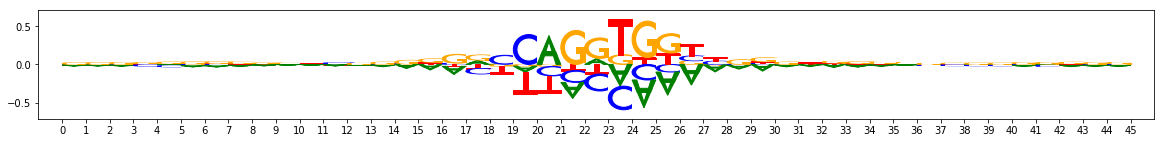

Task 0 actual importance scores:


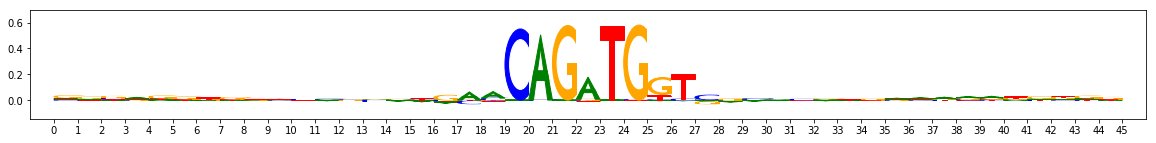

Task 1 hypothetical scores:


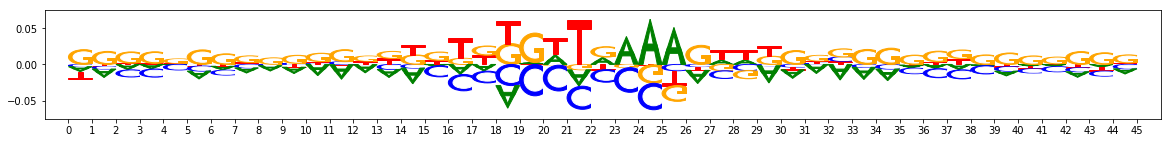

Task 1 actual importance scores:


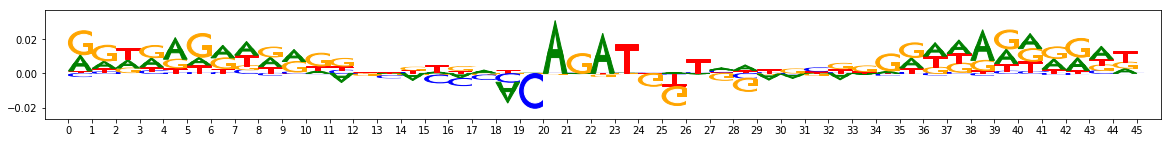

Task 2 hypothetical scores:


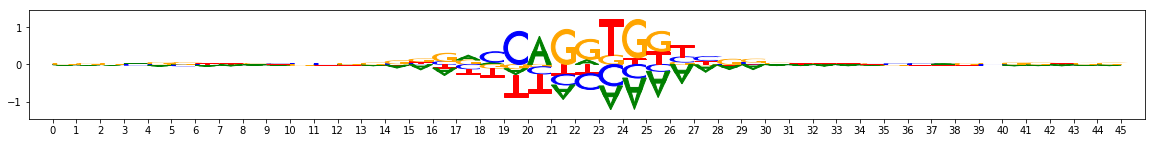

Task 2 actual importance scores:


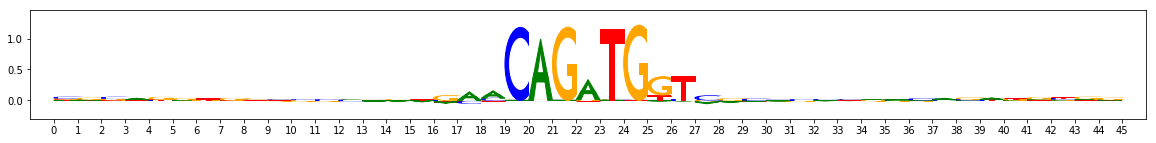

onehot, fwd and rev:


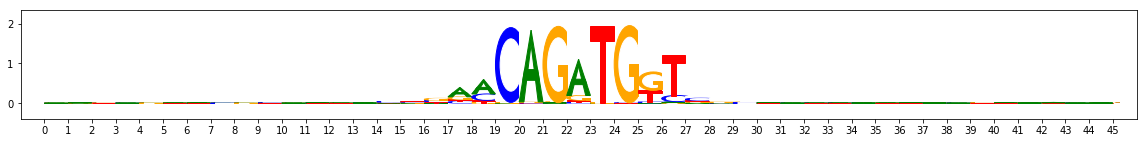

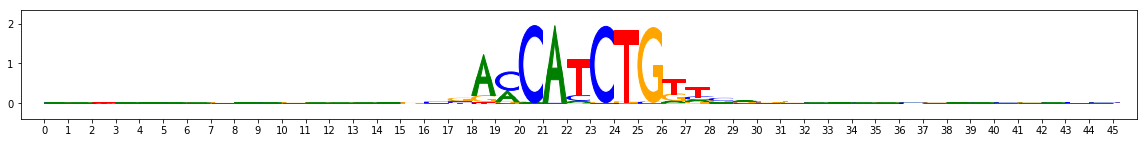

metacluster1
activity pattern: [1 1 0]
pattern_0
total seqlets: 333
Task 0 hypothetical scores:


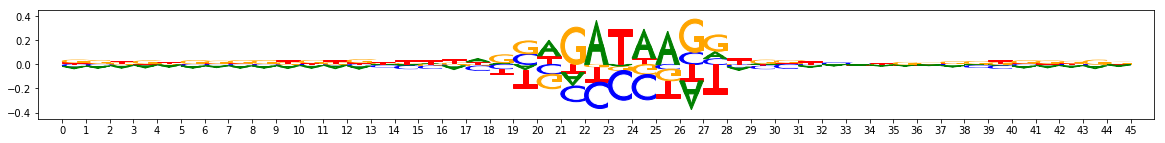

Task 0 actual importance scores:


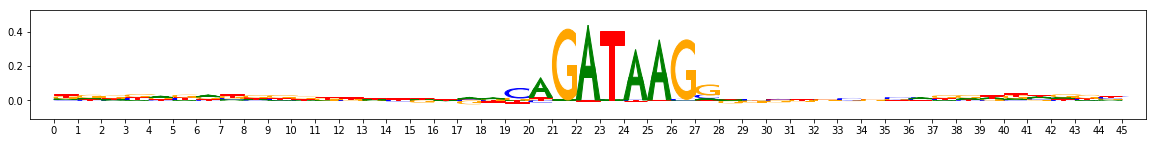

Task 1 hypothetical scores:


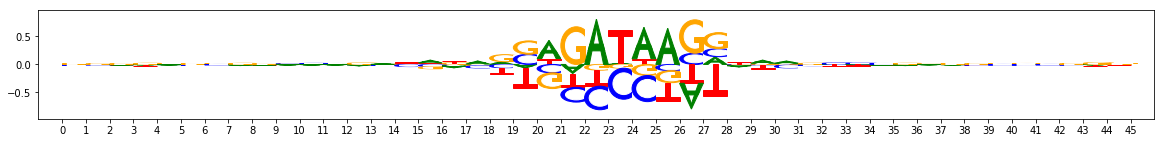

Task 1 actual importance scores:


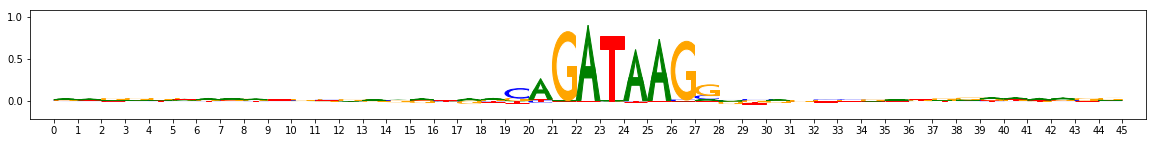

Task 2 hypothetical scores:


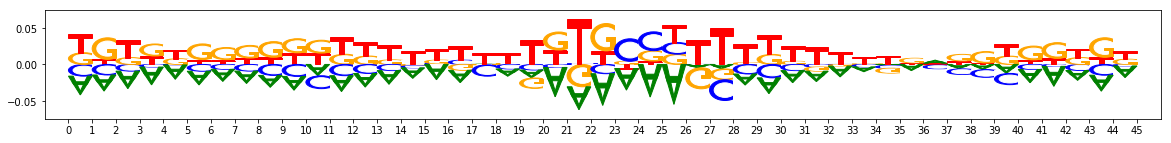

Task 2 actual importance scores:


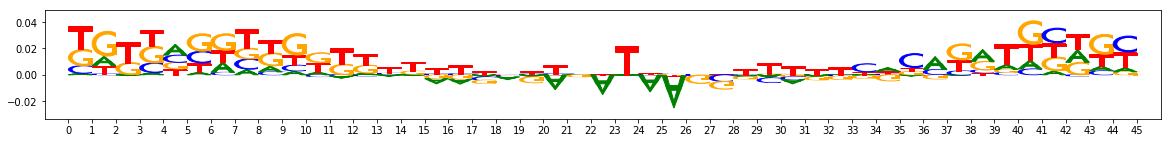

onehot, fwd and rev:


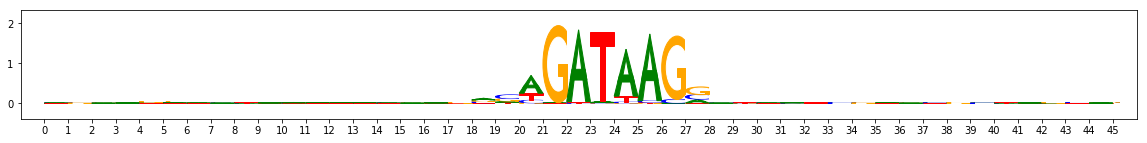

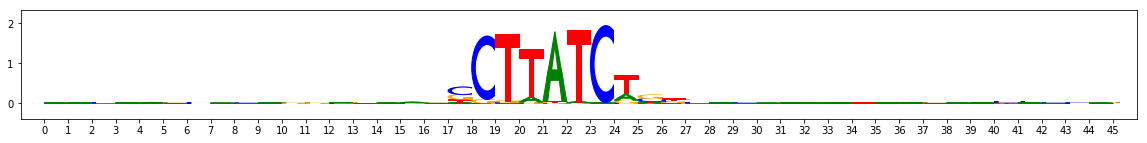

metacluster2
activity pattern: [0 1 0]
pattern_0
total seqlets: 136
Task 0 hypothetical scores:


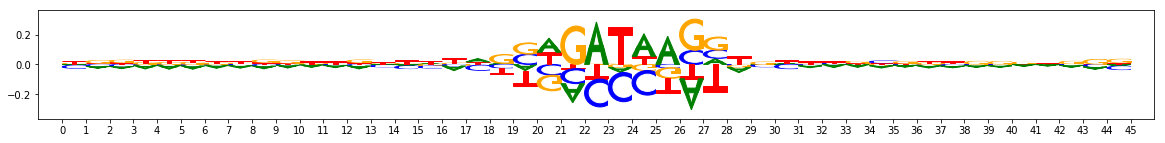

Task 0 actual importance scores:


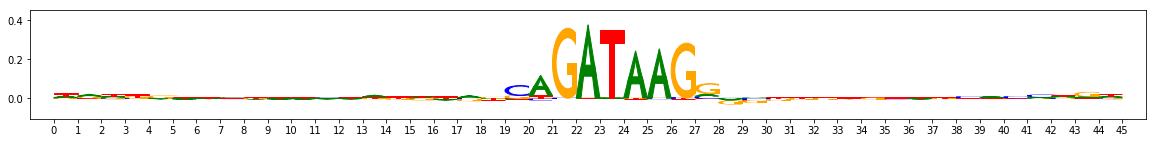

Task 1 hypothetical scores:


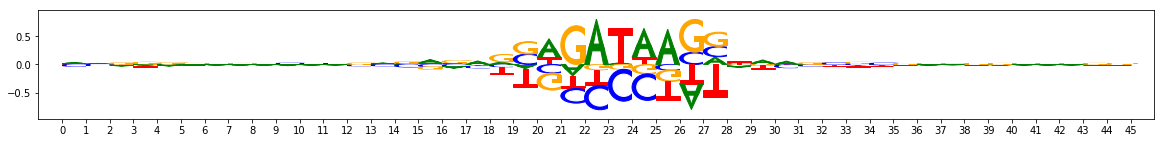

Task 1 actual importance scores:


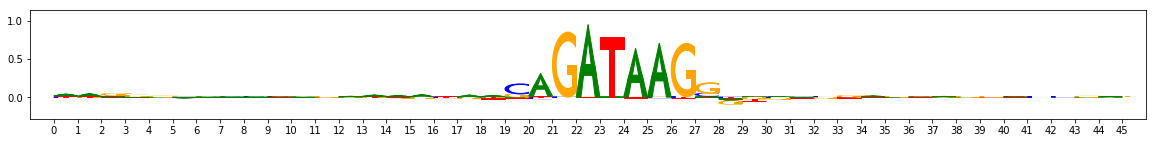

Task 2 hypothetical scores:


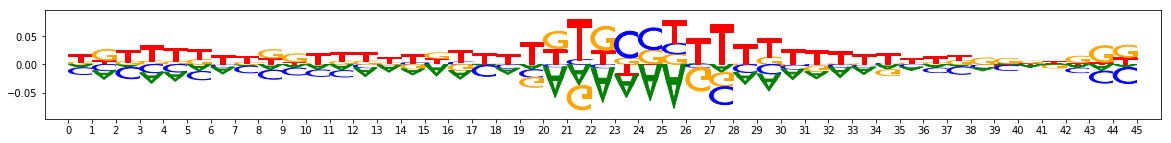

Task 2 actual importance scores:


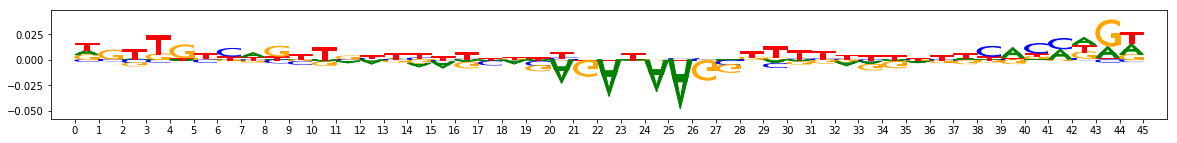

onehot, fwd and rev:


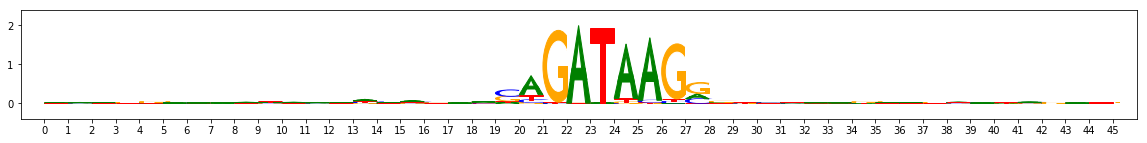

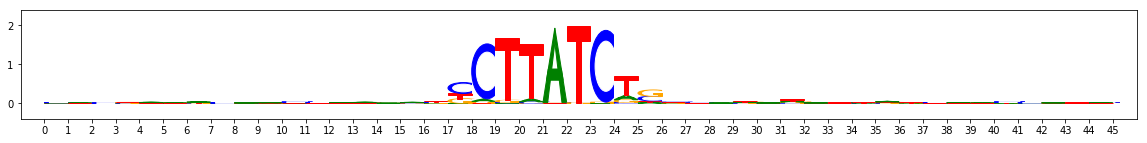

metacluster3
activity pattern: [0 0 1]
pattern_0
total seqlets: 174
Task 0 hypothetical scores:


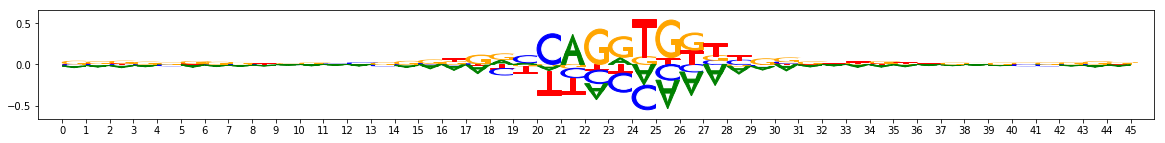

Task 0 actual importance scores:


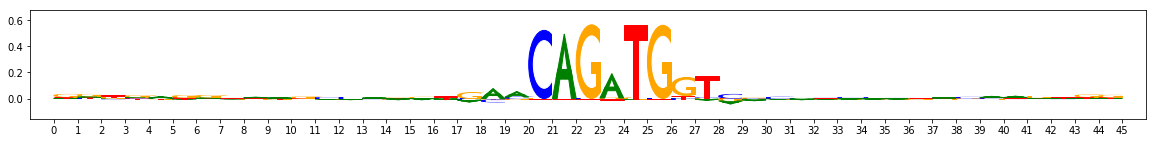

Task 1 hypothetical scores:


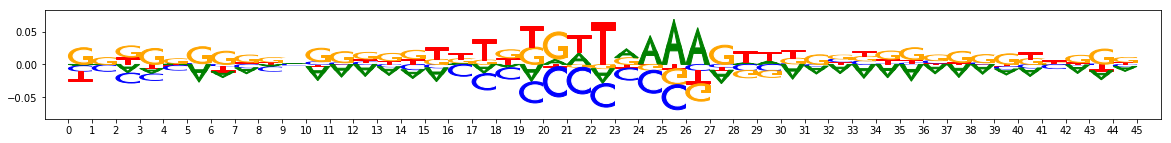

Task 1 actual importance scores:


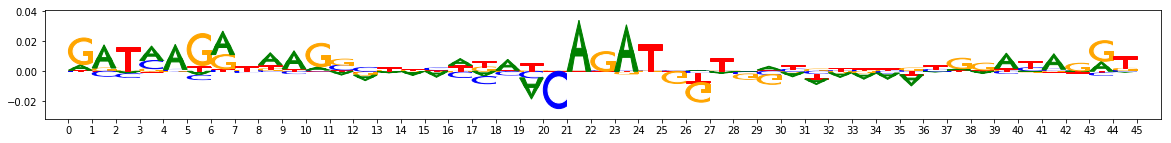

Task 2 hypothetical scores:


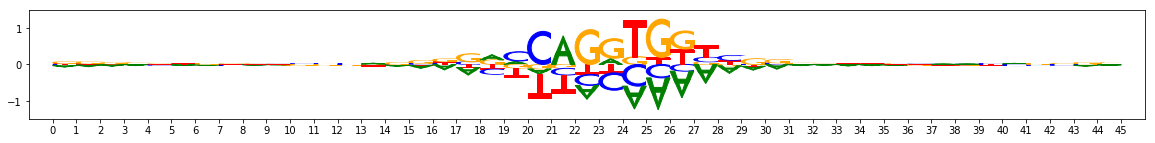

Task 2 actual importance scores:


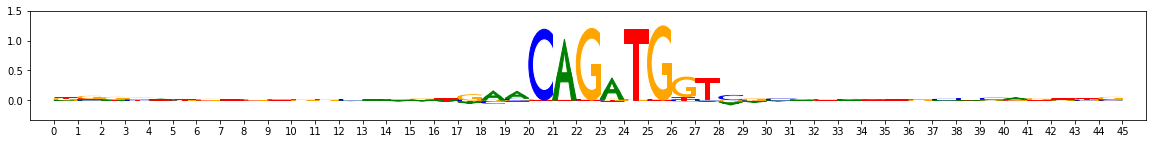

onehot, fwd and rev:


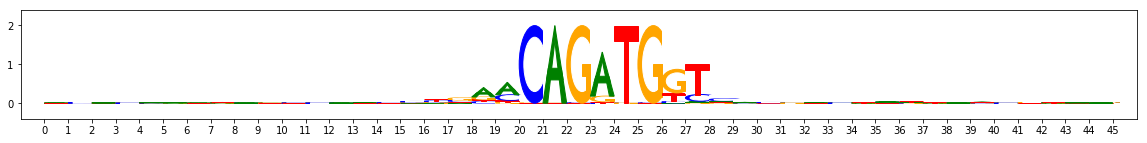

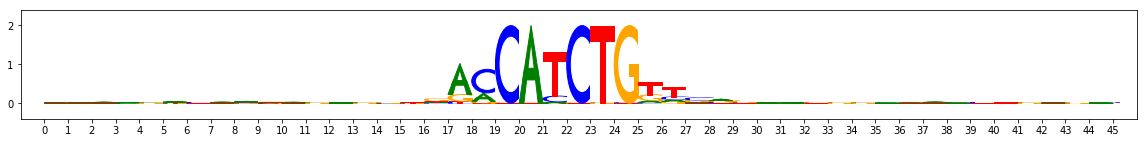

metacluster4
activity pattern: [1 1 1]


In [7]:
from collections import Counter
from modisco.visualization import viz_sequence
reload(viz_sequence)
from matplotlib import pyplot as plt

import modisco.affinitymat.core
reload(modisco.affinitymat.core)
import modisco.cluster.phenograph.core
reload(modisco.cluster.phenograph.core)
import modisco.cluster.phenograph.cluster
reload(modisco.cluster.phenograph.cluster)
import modisco.cluster.core
reload(modisco.cluster.core)
import modisco.aggregator
reload(modisco.aggregator)

hdf5_results = h5py.File("results.hdf5")

metacluster_names = list(hdf5_results["metaclustering_results"]["all_metacluster_names"][:])

for metacluster_name in metacluster_names:
    print(metacluster_name)
    metacluster_grp = (hdf5_results["metacluster_idx_to_submetacluster_results"]
                                   [metacluster_name])
    print("activity pattern:",metacluster_grp["activity_pattern"][:])
    all_pattern_names = (list(metacluster_grp["seqlets_to_patterns_result"]
                                             ["patterns"]["all_pattern_names"][:]))
    for pattern_name in all_pattern_names:
        print(pattern_name)
        pattern = metacluster_grp["seqlets_to_patterns_result"]["patterns"][pattern_name]
        print("total seqlets:",len(pattern["seqlets_and_alnmts"]["seqlets"]))
        background = np.array([0.27, 0.23, 0.23, 0.27])
        print("Task 0 hypothetical scores:")
        viz_sequence.plot_weights(pattern["task0_hypothetical_contribs"]["fwd"])
        print("Task 0 actual importance scores:")
        viz_sequence.plot_weights(pattern["task0_contrib_scores"]["fwd"])
        print("Task 1 hypothetical scores:")
        viz_sequence.plot_weights(pattern["task1_hypothetical_contribs"]["fwd"])
        print("Task 1 actual importance scores:")
        viz_sequence.plot_weights(pattern["task1_contrib_scores"]["fwd"])
        print("Task 2 hypothetical scores:")
        viz_sequence.plot_weights(pattern["task2_hypothetical_contribs"]["fwd"])
        print("Task 2 actual importance scores:")
        viz_sequence.plot_weights(pattern["task2_contrib_scores"]["fwd"])
        print("onehot, fwd and rev:")
        viz_sequence.plot_weights(viz_sequence.ic_scale(np.array(pattern["sequence"]["fwd"]),
                                                        background=background)) 
        viz_sequence.plot_weights(viz_sequence.ic_scale(np.array(pattern["sequence"]["rev"]),
                                                        background=background)) 
        
hdf5_results.close()